In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace import sarimax
import statsmodels.api as sm
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
!pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/7d/76/31fb9c58398f4cbdde4a0831d0407a1ca987fe828c7da9ce80969014a5a1/yfinance-0.2.40-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/6a/71/3656c00606e75e81f11721e6a1c973c3e03da8c7d8b665d20f78245384c6/frozendict-2.4.4-py311-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for html5lib>=1.1 from https://files.pythonhosted.org/packages/6c/dd/a834df6482147d48e225a49515aabc28974a

In [3]:
# Fetch Tesla's historical financial data

ticker = 'TSLA'

tesla_data = yf.download(ticker, start='2010-01-01', end='2024-07-01')

print(tesla_data.head())

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500


In [4]:
tesla_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...
2024-06-24,184.970001,188.800003,182.550003,182.580002,182.580002,61992100
2024-06-25,184.399994,187.970001,182.009995,187.350006,187.350006,63678300
2024-06-26,186.539993,197.759995,186.360001,196.369995,196.369995,95737100


## Preprocessing the Data

In [5]:
tesla_data.reset_index(inplace=True)
tesla_data = tesla_data[['Date', 'Close']]

tesla_data.set_index('Date', inplace=True)

In [6]:
tesla_data

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2024-06-24,182.580002
2024-06-25,187.350006
2024-06-26,196.369995


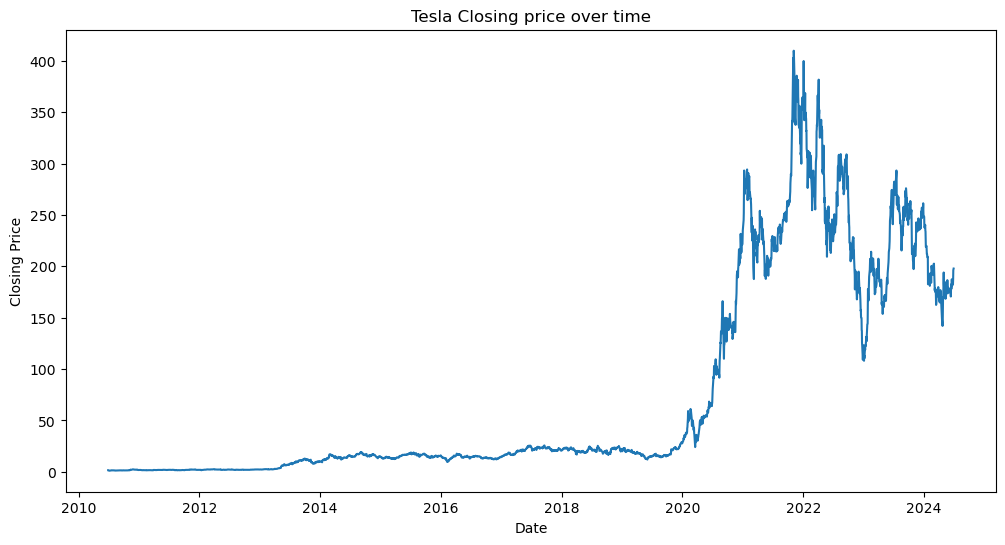

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(tesla_data['Close'])
plt.title('Tesla Closing price over time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

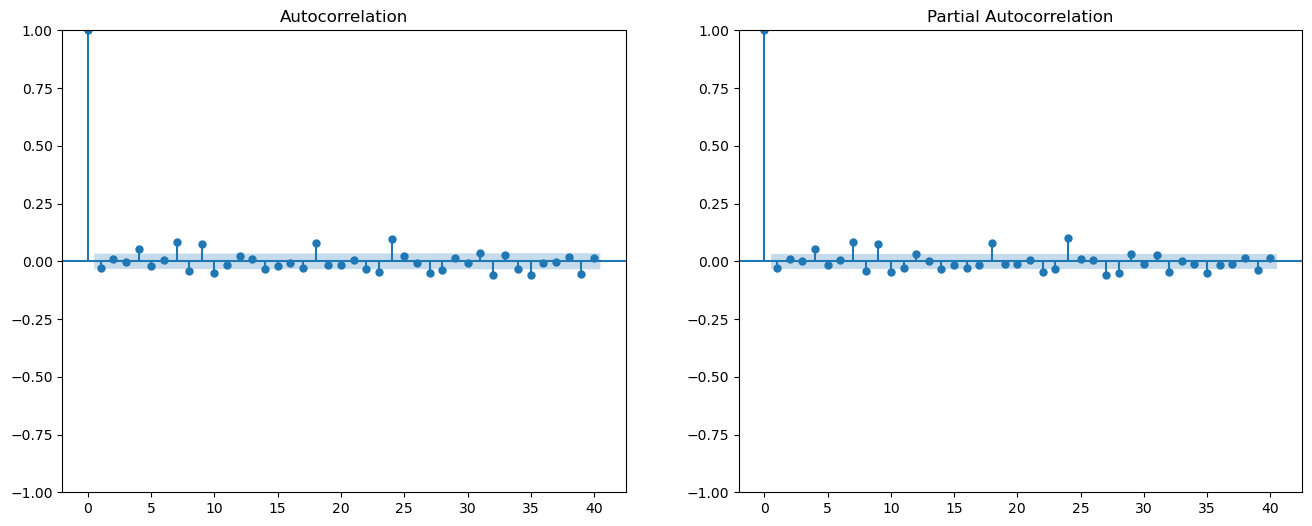

In [16]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(tesla_data['Close'].diff().dropna(), ax=axes[0], lags=40)
plot_pacf(tesla_data['Close'].diff().dropna(), ax=axes[1], lags=40)

plt.show()

In [18]:
# Define the p, d and q parameters to take any value between 0 and 4
p = d = q = range(0, 5)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Create a function to evaluate the ARIMA model
def evaluate_arima_model(data, arima_order):
    model = ARIMA(data, order=arima_order)
    model_fit = model.fit()
    return model_fit.aic

In [19]:
# Find the best ARIMA model
best_aic = float("inf")
best_order = None
for order in pdq:
    try:
        aic = evaluate_arima_model(tesla_data['Close'], order)
        if aic < best_aic:
            best_aic = aic
            best_order = order
    except:
        continue

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')

/Users/pranaypathole/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranaypathole/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranaypathole/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranaypathole/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency informatio

Best ARIMA order: (1, 4, 3) with AIC: 2238.9336692458637


/Users/pranaypathole/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
best_model = ARIMA(tesla_data['Close'], order=best_order)
best_model_fit = best_model.fit()

/Users/pranaypathole/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranaypathole/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/pranaypathole/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3524
Model:                 ARIMA(1, 4, 3)   Log Likelihood               -1114.467
Date:                Tue, 09 Jul 2024   AIC                           2238.934
Time:                        15:46:07   BIC                           2269.765
Sample:                             0   HQIC                          2249.934
                               - 3524                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9406   1.02e-05   9.26e+04      0.000       0.941       0.941
ma.L1         -2.9999   4.36e-10  -6.89e+09      0.000      -3.000      -3.000
ma.L2          2.9999   7.76e-10   3.87e+09      0.0

## Forecast

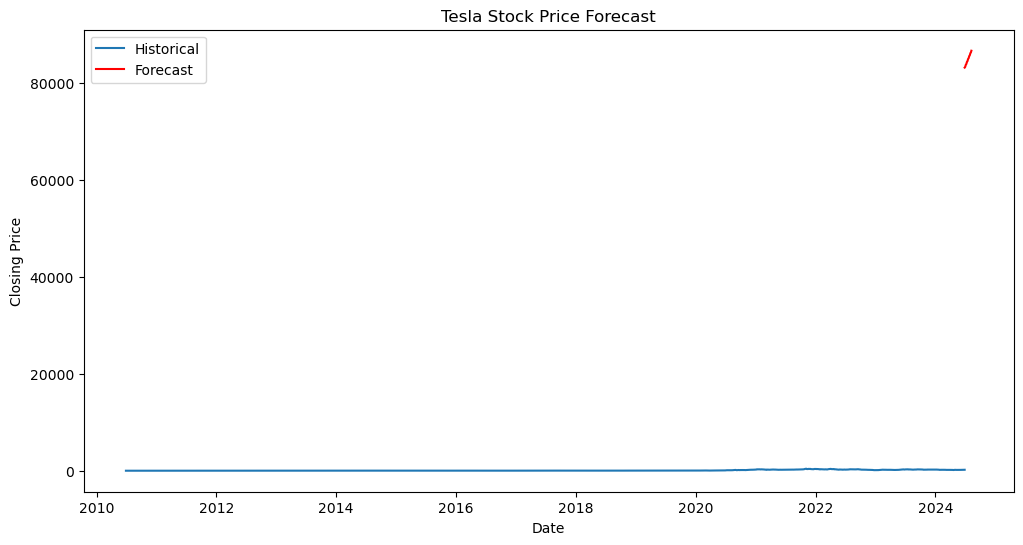

In [23]:
# Forecast for the next 30 days
forecast = best_model_fit.forecast(steps=30)
forecast_dates = pd.date_range(start=tesla_data.index[-1], periods=30, freq='B')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(tesla_data['Close'], label='Historical')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.title('Tesla Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## SARIMAX

In [24]:
# Define the p, d, q, P, D, Q parameters for seasonal ARIMA
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Create a function to evaluate the SARIMA model
def evaluate_sarima_model(data, arima_order, seasonal_order):
    model = sm.tsa.statespace.SARIMAX(data, order=arima_order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    return model_fit.aic

In [25]:
# Find the best SARIMA model
best_aic = float("inf")
best_order = None
best_seasonal_order = None
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            aic = evaluate_sarima_model(tesla_data['Close'], order, seasonal_order)
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

print(f'Best SARIMA order: {best_order} with seasonal order: {best_seasonal_order} and AIC: {best_aic}')

Best SARIMA order: None with seasonal order: None and AIC: inf


In [32]:
# Fit the best SARIMA model
best_sarima_model = sm.tsa.statespace.SARIMAX(tesla_data['Close'], order=best_order, seasonal_order=best_seasonal_order)
best_sarima_model_fit = best_sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.25728D+00    |proj g|=  7.10543D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.105D-10   6.257D+00
  F =   6.2572830957018084     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/pranaypathole/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [33]:
# Print model summary
print(best_sarima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3524
Model:                        SARIMAX   Log Likelihood              -22050.666
Date:                Tue, 09 Jul 2024   AIC                          44103.331
Time:                        15:59:07   BIC                          44109.499
Sample:                             0   HQIC                         44105.532
                               - 3524                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.594e+04    290.686     54.841      0.000    1.54e+04    1.65e+04
Ljung-Box (L1) (Q):                3517.49   Jarque-Bera (JB):               961.81
Prob(Q):                              0.00   Pr

/Users/pranaypathole/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranaypathole/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


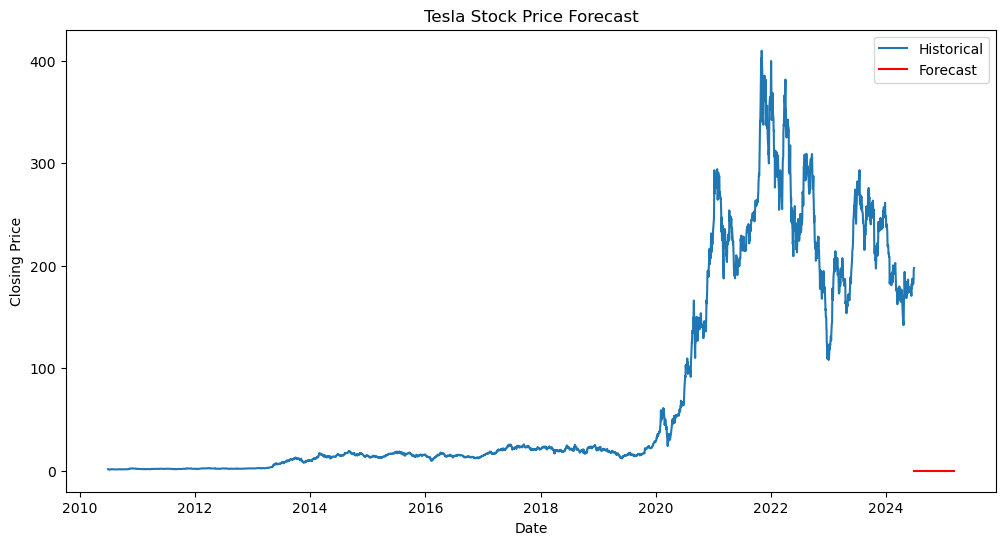

In [34]:
# Forecast for the next 180 days
forecast = best_sarima_model_fit.forecast(steps=180)
forecast_dates = pd.date_range(start=tesla_data.index[-1], periods=180, freq='B')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(tesla_data['Close'], label='Historical')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.title('Tesla Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## Training a regression model to do forecasting

In [37]:
tesla_data = yf.download('TSLA', start='2010-01-01', end='2024-07-07')

[*********************100%%**********************]  1 of 1 completed


In [38]:
tesla_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...
2024-06-28,199.550003,203.199997,195.259995,197.880005,197.880005,95438100
2024-07-01,201.020004,213.229996,200.850006,209.860001,209.860001,135691400
2024-07-02,218.889999,231.300003,218.059998,231.259995,231.259995,205047900


In [39]:
tesla_data['Year'] = tesla_data.index.year
tesla_data['Month'] = tesla_data.index.month
tesla_data['Day'] = tesla_data.index.day
tesla_data['DayOfWeek'] = tesla_data.index.dayofweek

features = tesla_data[['Year', 'Month', 'Day', 'DayOfWeek', 'Volume']]
target = tesla_data[['Close']]

In [40]:
print(features.head())

            Year  Month  Day  DayOfWeek     Volume
Date                                              
2010-06-29  2010      6   29          1  281494500
2010-06-30  2010      6   30          2  257806500
2010-07-01  2010      7    1          3  123282000
2010-07-02  2010      7    2          4   77097000
2010-07-06  2010      7    6          1  103003500


In [41]:
print(target.head())

               Close
Date                
2010-06-29  1.592667
2010-06-30  1.588667
2010-07-01  1.464000
2010-07-02  1.280000
2010-07-06  1.074000


In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [44]:
X_train

,Year,Month,Day,DayOfWeek,Volume
Date,,,,,
2012-08-07,2012,8,7,1,35808000
2023-09-05,2023,9,5,1,129469600
2020-09-25,2020,9,25,4,201625500
2017-01-18,2017,1,18,2,56535000
2016-04-06,2016,4,6,2,175582500
...,...,...,...,...,...
2014-12-23,2014,12,23,1,67585500
2015-08-19,2015,8,19,2,54064500
2013-11-26,2013,11,26,1,208282500


In [45]:
X_test

,Year,Month,Day,DayOfWeek,Volume
Date,,,,,
2011-10-11,2011,10,11,1,8635500
2022-09-20,2022,9,20,1,61642800
2021-11-16,2021,11,16,1,79627200
2013-06-17,2013,6,17,0,105993000
2011-09-02,2011,9,2,4,11548500
...,...,...,...,...,...
2023-12-26,2023,12,26,1,86892400
2022-11-02,2022,11,2,2,63070300
2022-06-21,2022,6,21,1,122793000


In [46]:
y_train

,Close
Date,
2012-08-07,2.016667
2023-09-05,256.489990
2020-09-25,135.779999
2017-01-18,15.890667
2016-04-06,17.694668
...,...
2014-12-23,14.731333
2015-08-19,17.016666
2013-11-26,8.033333


In [47]:
y_test

,Close
Date,
2011-10-11,1.840667
2022-09-20,308.730011
2021-11-16,351.576660
2013-06-17,6.813333
2011-09-02,1.538000
...,...
2023-12-26,256.609985
2022-11-02,214.979996
2022-06-21,237.036667


In [48]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [49]:
model

LinearRegression()

In [50]:
print(model.coef_)
print(model.intercept_)

[[ 2.18804375e+01  1.77035595e+00 -2.59795011e-02 -6.14789195e-01
  -2.86866578e-07]]
[-44041.14183849]


In [52]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)

In [53]:
mse

3837.551138298567

In [54]:
r2_score

0.638449078421776

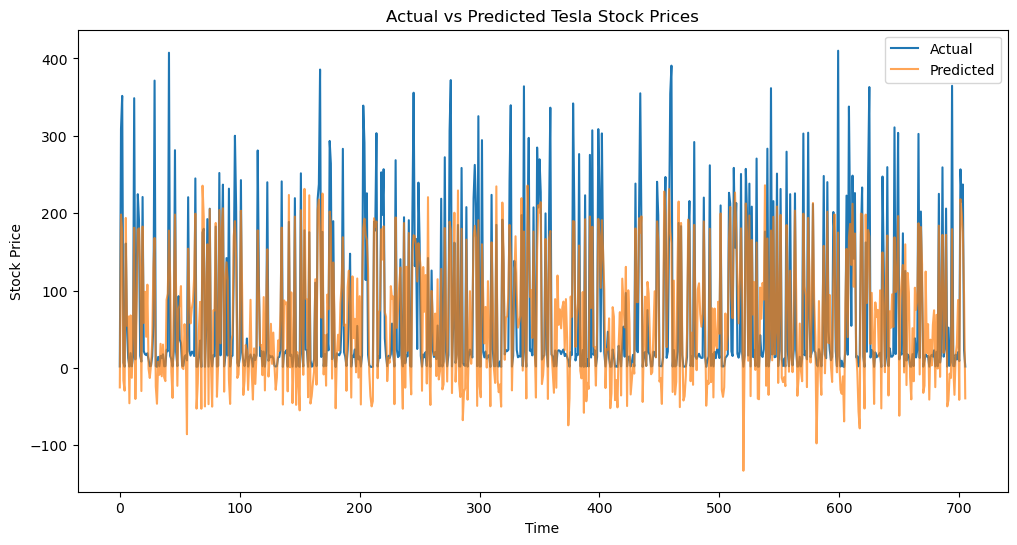

In [55]:
# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Tesla Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [61]:
# Create a DataFrame for actual and predicted values
results = pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted': y_pred.ravel()}, index=y_test.index)

In [62]:
results

,Actual,Predicted
Date,,
2011-10-11,1.840667,-25.256238
2022-09-20,308.730011,198.218381
2021-11-16,351.576660,174.823450
2013-06-17,6.813333,-16.046487
2011-09-02,1.538000,-29.472788
...,...,...
2023-12-26,256.609985,218.010743
2022-11-02,214.979996,201.202432
2022-06-21,237.036667,175.339385


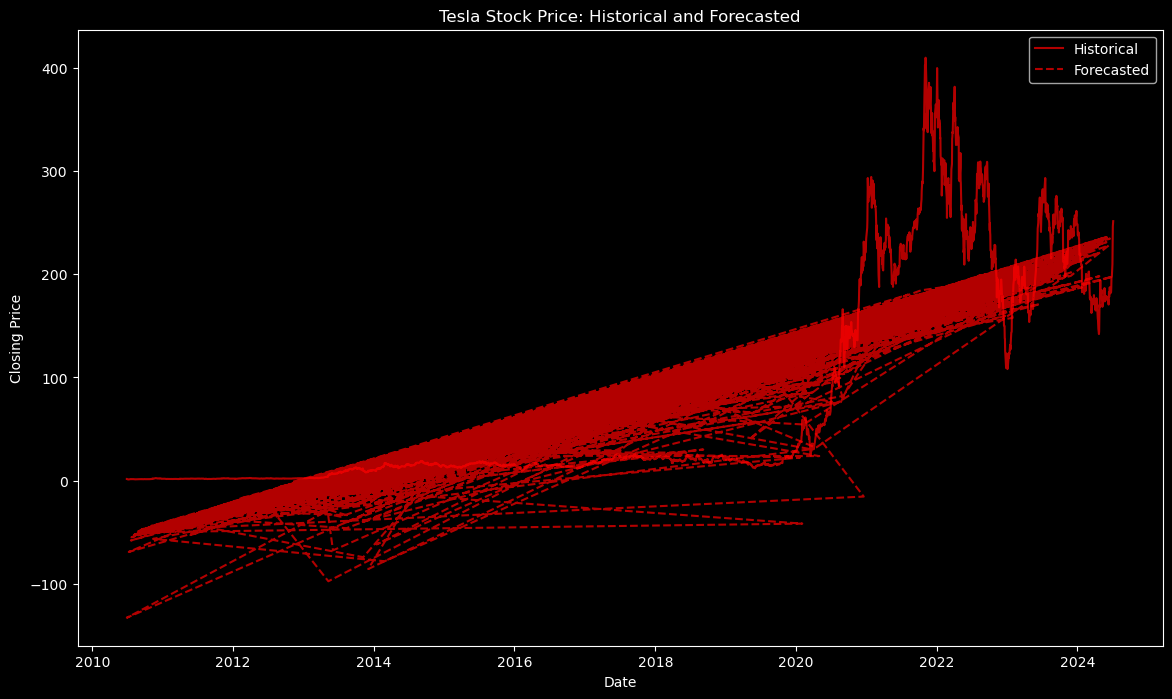

In [65]:
# Plot the actual vs predicted values with enhanced visualization
plt.figure(figsize=(14, 8))


# Plot historical values in a solid red line
plt.plot(tesla_data.index, tesla_data['Close'], color='red', label='Historical', alpha=0.7)

# Plot forecasted values in a dotted red line
plt.plot(results.index, results['Predicted'], 'r--', label='Forecasted', alpha=0.7)

# Set titles and labels with white font
plt.title('Tesla Stock Price: Historical and Forecasted', color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Closing Price', color='white')

# Set the tick color to white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Add legend
plt.legend()

# Show the plot
plt.show()

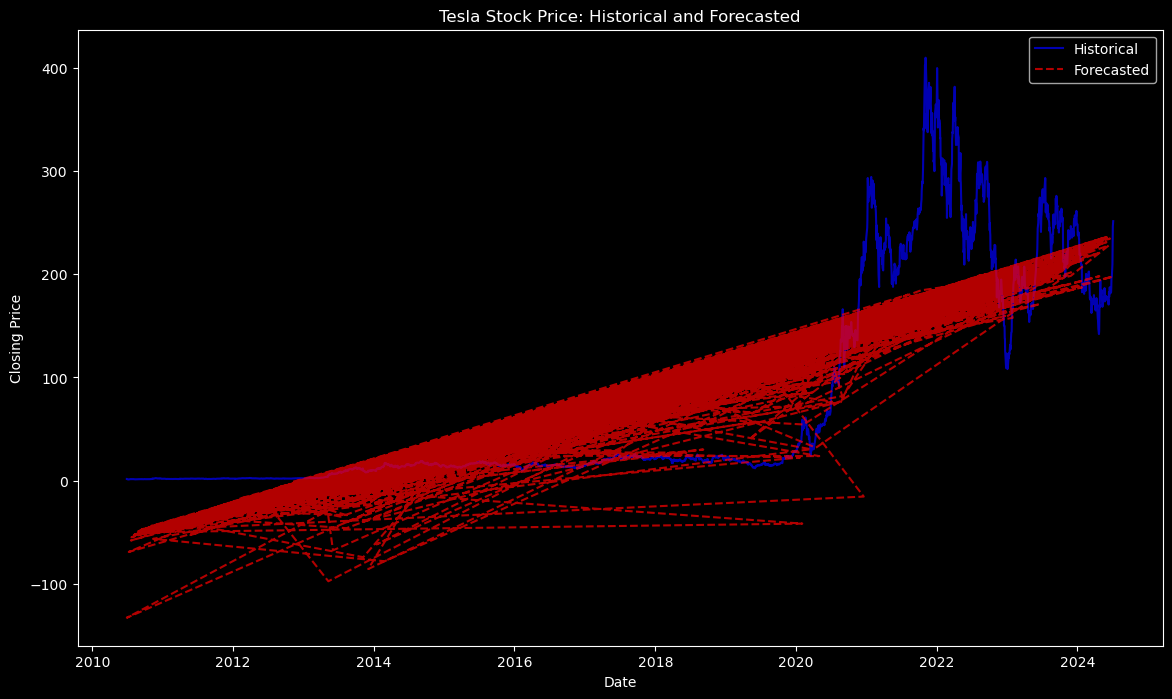

In [66]:
# Plot the actual vs predicted values with standard visualization
plt.figure(figsize=(14, 8))

# Plot historical values in a solid blue line
plt.plot(tesla_data.index, tesla_data['Close'], color='blue', label='Historical', alpha=0.7)

# Plot forecasted values in a dotted red line
plt.plot(results.index, results['Predicted'], 'r--', label='Forecasted', alpha=0.7)

# Set titles and labels
plt.title('Tesla Stock Price: Historical and Forecasted')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Add legend
plt.legend()

# Show the plot
plt.show()